# Initializations

In [199]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up data sources

In [200]:
dataroot = "/home/adalbert/data/world-cities/"

#### Training data is in ./train (all cities > 10k population)

In [201]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])

len(files_df)

25038

#### Preprocessing: assign class of "built area"
- by deciles

In [202]:
from skimage.io import imread

def compute_built_area(f):
    img = imread(f)
    img[img==128] = 0
    return (img > 0).sum() / float(img.shape[0]*img.shape[1])

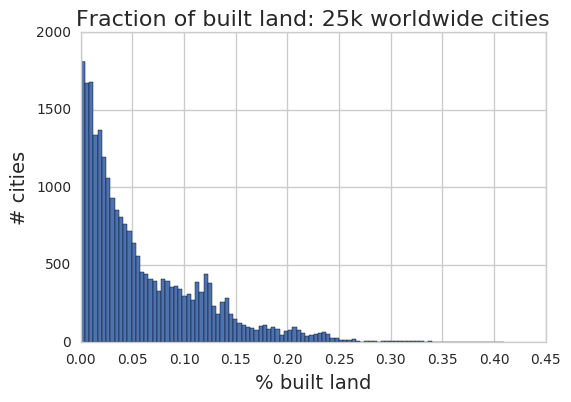

In [203]:
files_df['built pct'] = files_df['filename'].apply(compute_built_area)

files_df['built pct'].hist(bins=100, figsize=(6,4))
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

In [204]:
q = files_df['built pct'].quantile(np.linspace(0.1,1,10))
files_df['decile'] = files_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )

#### Split into training and validation

In [51]:
idx = np.random.choice(range(len(files_df)), int(len(files_df)*0.95), \
                       replace=False)
train_df = files_df.iloc[idx]
valid_df  = files_df.iloc[list(set(range(len(files_df))) - set(idx))]

train_df.to_csv(dataroot + "/train.csv")
valid_df.to_csv(dataroot + "/valid.csv")

len(train_df), len(valid_df)

(23786, 1252)

#### Test data is under ./test/ and contains more carefully-filtered samples

In [205]:
import glob

files = glob.glob(dataroot + "/test/*/*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

len(test_df)

3071

In [206]:
test_df['built pct'] = test_df['filename'].apply(compute_built_area)
test_df['decile'] = test_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )

test_df.to_csv(dataroot + "/test.csv")


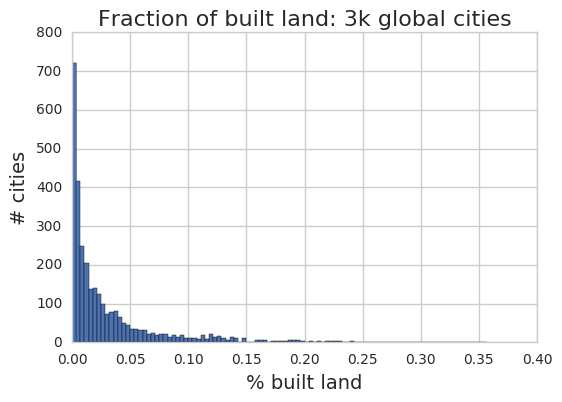

In [207]:
test_df['built pct'].hist(bins=100, figsize=(6,4))
plt.title("Fraction of built land: 3k global cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

# Train GAN -- done externally
We could spawn external process, but better just copy the command into an external script and run in a separate terminal. 

In [208]:
import sys
sys.path.append("/home/adalbert/nbserver/urbanization-patterns/models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, default_loader

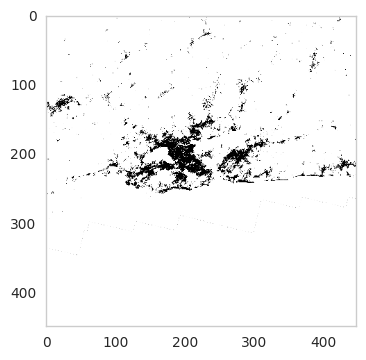

In [210]:
val_nodata = 128

pimg = grayscale_loader(test_df['filename'].iloc[0])

plt.imshow(pimg)

# Plot fake and real samples

In [1]:
experiment_dir = "/home/adalbert/nbserver/pytorch-workspace/DCGAN/25k-cities-128/"

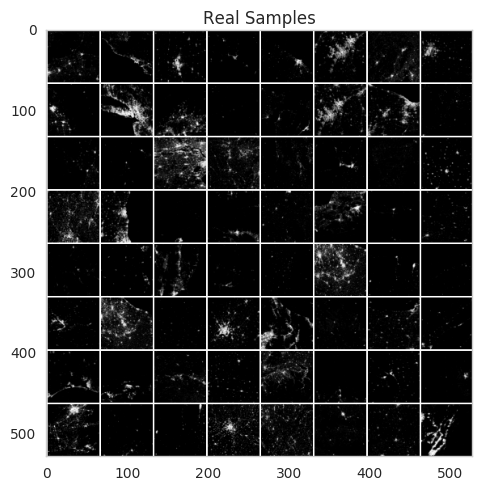

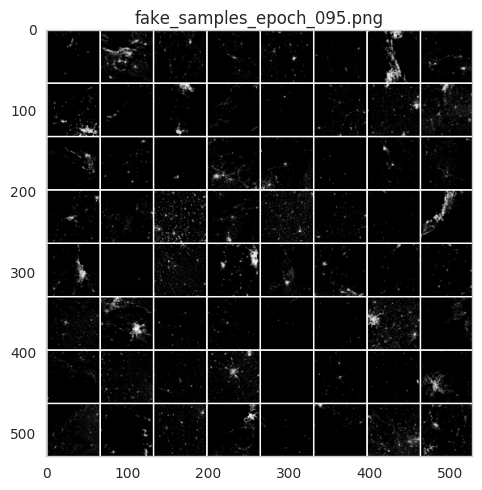

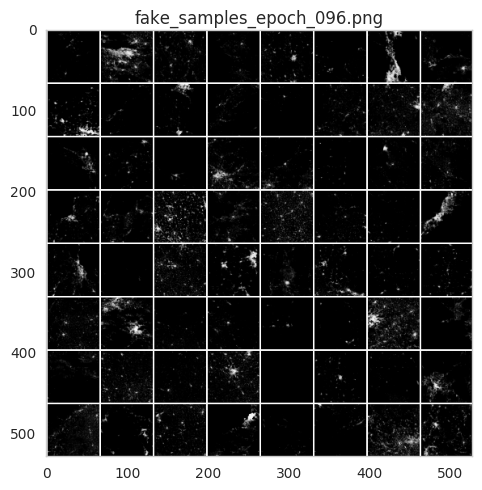

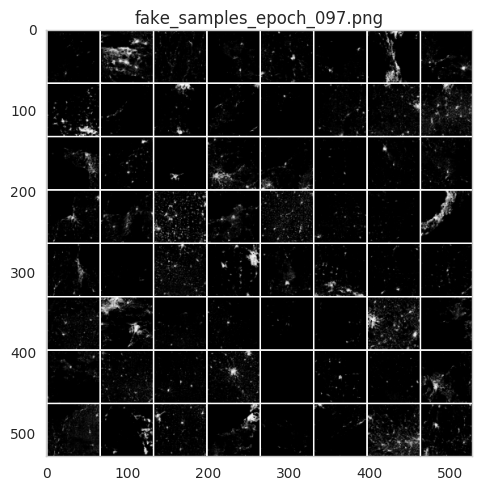

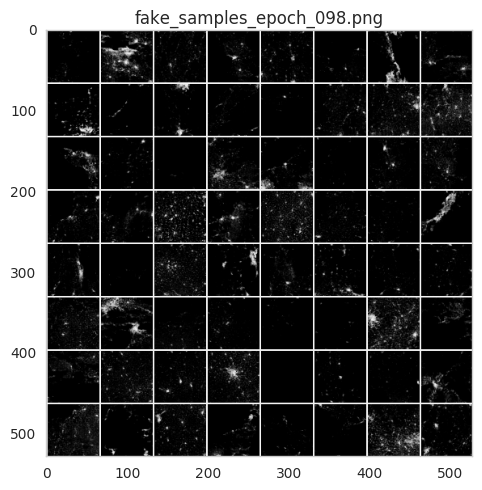

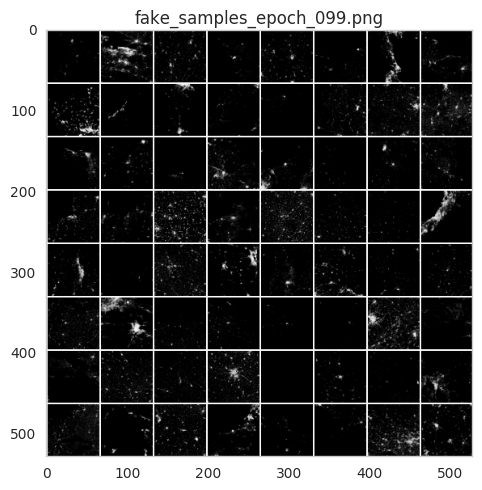

In [18]:
files_fake = glob.glob(experiment_dir + "/fake*.png")
files_fake.sort(key=lambda x: int(os.path.basename(x).split("_")[-1].replace(".png","")))

files_real = glob.glob(experiment_dir + "/real*.png")

plt.imshow(imread(files_real[0]))
plt.title("Real Samples")
plt.show()

for f in files_fake[-5:]:
    img = imread(f)
    plt.imshow(img)
    plt.title(os.path.basename(f))
    plt.show()

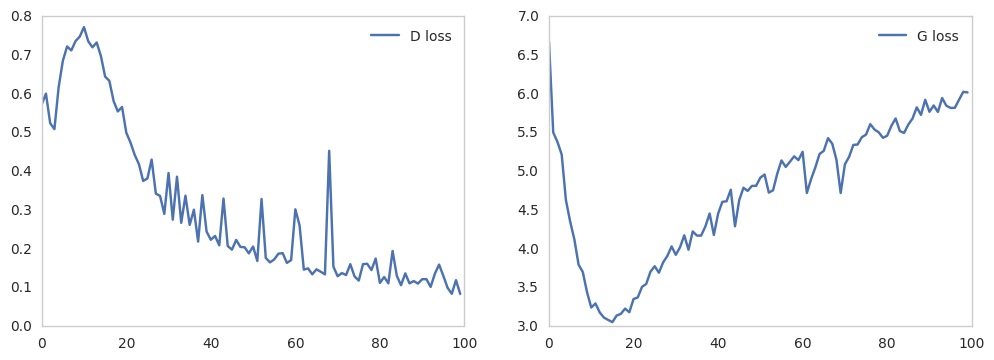

In [19]:
import cPickle as pickle
import gzip

with gzip.open(experiment_dir + "./training-loss.pickle.gz", "r") as f:
    lossD, lossG = pickle.load(f)
    
lossD = np.array(lossD)
lossG = np.array(lossG)

# plot
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lossD[:,0], label="D loss")
ax[0].legend()
ax[1].plot(lossG[:,0], label="G loss")
ax[1].legend()

# Explore latent space 
 - a way to assess representation quality introduced in the DCGAN paper

#### Load last checkpointed generator model

In [23]:
files_cptG = glob.glob(experiment_dir + "/netG*.pth")
files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}

In [33]:
sys.path.append("../models/")
import models.dcgan_orig as do

nz   = 100
ngf  = 64
nc   = 1
ngpu = 2
netG = do._netG(ngpu, nc, nz, ngf)

netG.load_state_dict(torch.load(files_cptG[np.argmax(files_cptG.keys())]))

# generator = nn.Sequential(*list(list(netG.children())[0].children())[:-2])

#### Generate interpolation map

In [185]:
def generate_interpolation_map(Z,M):
    N, nz = Z.shape
    Z_map = np.zeros((N-1,M,nz))
    for n in range(N-1):
        dZ = (Z[n+1,:] - Z[n,:]) / float(M)
        for m in range(M):
            Z_map[n,m,:] = Z[n,:] + m*dZ
    Z_map = Z_map.reshape(((N-1)*M, nz))
    return Z_map

def generate_samples(Z):
    print Z.shape
    N, nz = Z.shape
    Zv = torch.FloatTensor(Z.reshape(N, nz, 1, 1))
    Zv = Variable(Zv)
    fake = netG(Zv)
    return fake

In [183]:
N = 10
M = 10

Z = np.random.rand(N, nz)

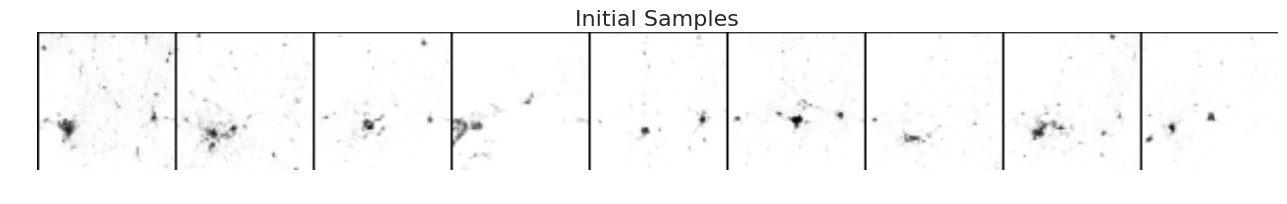

In [175]:
fake = generate_samples(Z)

canvas = vutils.make_grid(fake.data, nrow=M-1, padding=1).numpy()

plt.figure(figsize=(16,4))
plt.imshow(canvas[0,:,:])
plt.axis("off")
plt.title("Initial Samples", fontsize=16)

(90, 100)


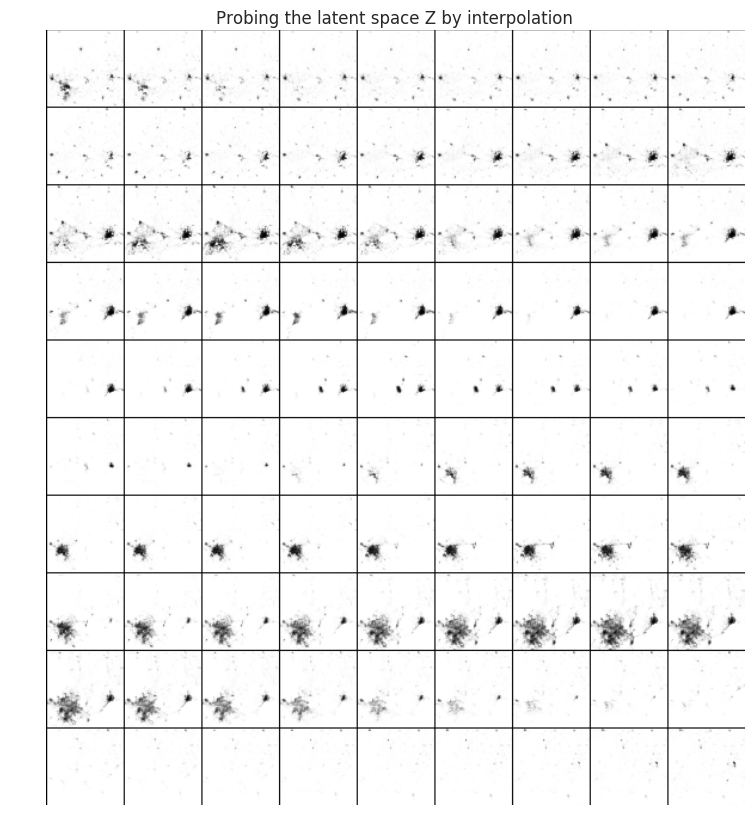

In [184]:
Z_map = generate_interpolation_map(Z, M)
fake = generate_samples(Z_map)

canvas = vutils.make_grid(fake.data, nrow=M-1, padding=1).numpy()

plt.figure(figsize=(24,10))
plt.imshow(canvas[1,:,:])
plt.axis("off")
plt.title("Probing the latent space Z by interpolation")

# Extract features for test samples

#### Load discriminator

In [188]:
# get checkpoints

files_cptD = glob.glob(experiment_dir + "/netD*.pth")
files_cptD = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptD}

last_checkpoint = files_cptD[np.argmax(files_cptD.keys())]

In [192]:
sys.path.append("../models/")
import models.dcgan_orig as do

ndf  = 64
nc   = 1
ngpu = 2
netD = do._netD(ngpu, nc, ndf)

netD.load_state_dict(torch.load(best_checkpoint))

feature_extractor = nn.Sequential(*list(list(netD.children())[0].children())[:-2])

#### Set up test data sources

In [215]:
sys.path.append("./../models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader
import torchvision.transforms as transforms

test_df = pd.read_csv(dataroot + "/test.csv")

imageSize = 64
batchSize = 64
workers   = 4

dataset = ImageDataFrame(df=test_df,
                         loader=grayscale_loader,
                         transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.CenterCrop(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                     shuffle=False, num_workers=int(workers))


#### Extract features from discriminator

In [218]:
from torch.autograd import Variable

input = torch.FloatTensor(batchSize, nc, imageSize, imageSize)

if torch.cuda.is_available():
    netD.cuda()
    input = input.cuda()

input = Variable(input)

labels = []
features = []
for i, data in enumerate(dataloader):
    netD.zero_grad()
    real_cpu, lab_batch = data
    batch_size = real_cpu.size(0)
    input.data.resize_(real_cpu.size()).copy_(real_cpu)
    feat_batch = feature_extractor(input)
    feat_batch = feat_batch.data.cpu().numpy().reshape((batch_size,-1))
    
    features.append(feat_batch)
    labels.append(lab_batch.numpy())

features = np.vstack(features)
labels = np.hstack(labels)

In [221]:
features.shape

(3071, 8192)

# Project to latent space via t-SNE

In [220]:
sys.path.append("../../topicsne/")

from wrapper import Wrapper
# from tsne import TSNE
from vtsne import VTSNE


In [222]:
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import squareform
from matplotlib.patches import Ellipse

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np


def preprocess(perplexity=30, metric='euclidean'):
    """ Compute pairiwse probabilities for MNIST pixels.
    """
    digits = datasets.load_digits(n_class=6)
    pos = digits.data
    y = digits.target
    n_points = pos.shape[0]
    distances2 = pairwise_distances(pos, metric=metric, squared=True)
    # This return a n x (n-1) prob array
    pij = manifold.t_sne._joint_probabilities(distances2, perplexity, False)
    # Convert to n x n prob array
    pij = squareform(pij)
    return n_points, pij, y


draw_ellipse = True
n_points, pij2d, y = preprocess()
i, j = np.indices(pij2d.shape)
i = i.ravel()
j = j.ravel()
pij = pij2d.ravel().astype('float32')
# Remove self-indices
idx = i != j
i, j, pij = i[idx], j[idx], pij[idx]

In [229]:
i.shape

(1171806,)

In [ ]:
n_topics = 2
n_dim = 2
print(n_points, n_dim, n_topics)

model = VTSNE(n_points, n_topics, n_dim)
wrap = Wrapper(model, batchsize=4096, epochs=1)


In [ ]:
n_topics = 2
n_dim = 2
print(n_points, n_dim, n_topics)

model = VTSNE(n_points, n_topics, n_dim)
wrap = Wrapper(model, batchsize=4096, epochs=1)
for itr in range(500):
    wrap.fit(pij, i, j)

    # Visualize the results
    embed = model.logits.weight.cpu().data.numpy()
    f = plt.figure()
    if not draw_ellipse:
        plt.scatter(embed[:, 0], embed[:, 1], c=y * 1.0 / y.max())
        plt.axis('off')
        plt.savefig('scatter_{:03d}.png'.format(itr), bbox_inches='tight')
        plt.close(f)
    else:
        # Visualize with ellipses
        var = np.sqrt(model.logits_lv.weight.clone().exp_().cpu().data.numpy())
        ax = plt.gca()
        for xy, (w, h), c in zip(embed, var, y):
            e = Ellipse(xy=xy, width=w, height=h, ec=None, lw=0.0)
            e.set_facecolor(plt.cm.Paired(c * 1.0 / y.max()))
            e.set_alpha(0.5)
            ax.add_artist(e)
        ax.set_xlim(-9, 9)
        ax.set_ylim(-9, 9)
        plt.axis('off')
        plt.savefig('scatter_{:03d}.png'.format(itr), bbox_inches='tight')
        plt.close(f)

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=50)

feat_reduced = pca.fit_transform(features)[:,:40]

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Components Variance Explained")
plt.xlabel("# components")
plt.ylabel("% variance")

# Clustering test samples

In [ ]:
# # https://github.com/DmitryUlyanov/Multicore-TSNE

# from MulticoreTSNE import MulticoreTSNE as TSNE

# tsne = TSNE(n_components=20, perplexity=30)
# feats_tsne = tsne.fit_transform(features.astype(np.float64))

In [ ]:
from sklearn.cluster import KMeans
loss_vec = []
k_vec = np.linspace(5, 150, 40)
for k in k_vec:
    print int(k),
    kmeans = KMeans(n_clusters=int(k), random_state=0).fit(feat_reduced)
    loss = -kmeans.score(feat_reduced)
    loss_vec.append(loss)

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(k_vec, np.array(loss_vec)/1e6)
plt.title("K-Means loss vs # clusters")
plt.xlabel("# Clusters")
plt.ylabel("loss (/1e6)")

In [ ]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(feat_reduced)

C = kmeans.predict(feat_reduced)

In [ ]:
(pd.Series(C).value_counts() / float(len(C))).plot(kind="barh", figsize=(4,4))
plt.title("Cluster Membership Distribution")
plt.xlabel("pct membership")
plt.ylabel("cluster ID")

In [ ]:
def plot_examples(image_paths, labels, classes=None, \
                  nExamples=10, thumbSize = (64,64), title="example"):
    # build example canvass 
    from skimage.transform import resize
    from skimage.io import imread
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.zeros((thumbSize[0]*nClusters, nExamples*thumbSize[1]))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = imread(image_paths[idx[j]])
            img = img / float(img.max())
            img[abs(img-0.5)<0.01] = 0 # hack to remove no-data patches
            img = 1-img
            img = resize(img, thumbSize)
            canvas[i*thumbSize[0]:(i+1)*thumbSize[0], j*thumbSize[1]:(j+1)*thumbSize[1]] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

In [ ]:
plot_examples(test_df['filename'].values, C)

In [ ]:
test_df.head()

In [ ]:
# Clustering analysis
- 